# Stock Price Prediction — Amazon (AMZN)
## Notebook 1 — Data Collection & Exploratory Data Analysis (EDA)

### Objective
The purpose of this notebook is to:
1. Download and store historical Amazon (AMZN) daily market data.
2. Inspect data quality (missing values, types, date range).
3. Perform basic exploratory analysis (price evolution, returns distribution, volatility, volume).
4. Conduct advanced EDA: stationarity tests, autocorrelation, seasonality effects, rolling correlation with S&P500, and drawdown analysis.
5. Produce clean outputs that will be reused in the next notebooks (feature engineering and modeling).

### Why this matters
A machine learning model is only as good as the data pipeline behind it. Before creating features or training models, we must ensure:
- the dataset is reliable,
- the time range is correct,
- variables are clearly understood,
- and no data leakage is introduced later.

## 1. Data Source

We use historical daily stock data for **Amazon (ticker: AMZN)** obtained from **Yahoo Finance**.
The data is downloaded programmatically using the **Python `yfinance` library**, which provides:
- Open, High, Low, Close prices (OHLC),
- Adjusted Close (Adj Close),
- Trading Volume.

### Why “Adj Close”?
For long historical periods, the **Adjusted Close** is often preferred because it accounts for corporate actions (e.g., stock splits and dividends). This makes the time series more consistent over time and reduces distortions when analyzing long-term trends.
In this project, we will use **Adj Close as our main price reference**.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 2. Download Configuration

We download daily data for:

- **AMZN (Amazon stock)**
- **^GSPC (S&P 500 Index — market benchmark)**

Period: **2005-01-01 to 2025-01-01**

### Why start in 2005?

Using a long historical window allows the analysis to capture multiple market regimes and structural shifts, including:

- The 2008 Global Financial Crisis,
- Extended bull market periods (2010–2019),
- The COVID-19 crash and recovery (2020),
- Recent inflationary and interest rate tightening cycles.

Training and analyzing models across different macroeconomic environments improves robustness and reduces the risk of overfitting to a single market phase.

### Why include the S&P 500?

The S&P 500 serves as a market benchmark.  
Including it allows:

- Relative performance comparison,
- Correlation analysis,
- Systematic vs idiosyncratic risk assessment,
- Market-adjusted return analysis in later stages.

In [54]:
amazon = yf.download("AMZN", start="2005-01-01", end="2025-01-01", auto_adjust=False)
amazon.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2005-01-03,2.2260,2.2260,2.2720,2.2105,2.2475,208930000
2005-01-04,2.1070,2.1070,2.1630,2.0750,2.1335,388370000
2005-01-05,2.0885,2.0885,2.1380,2.0780,2.0785,167084000
2005-01-06,2.0525,2.0525,2.1125,2.0450,2.0905,174018000
2005-01-07,2.1160,2.1160,2.1345,2.0580,2.0690,196732000


In [55]:
sp500 = yf.download("^GSPC", start="2005-01-01", end="2025-01-01", auto_adjust=False)
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2005-01-03,1202.079956,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1186.189941,1192.199951,1182.160034,1187.890015,1477900000


## 3. Initial Data Inspection

We start by inspecting:
- dataset shape (number of rows, columns),
- date range and frequency,
- data types (float, int),
- missing values,
- and basic descriptive statistics.

This step ensures the dataset is consistent and ready for transformations (returns, features, target creation).

In [56]:
print("\nAMAZON DATAFRAMES:\n")
amazon.columns = amazon.columns.get_level_values(0)
amazon.info()
amazon.describe()
amazon.isna().sum()


AMAZON DATAFRAMES:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2005-01-03 to 2024-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5033 non-null   float64
 1   Close      5033 non-null   float64
 2   High       5033 non-null   float64
 3   Low        5033 non-null   float64
 4   Open       5033 non-null   float64
 5   Volume     5033 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.2 KB


Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [57]:
print("\nS&P 500 DATAFRAMES:\n")
sp500.columns = sp500.columns.get_level_values(0)
sp500.info()
sp500.describe()
sp500.isna().sum()


S&P 500 DATAFRAMES:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2005-01-03 to 2024-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5033 non-null   float64
 1   Close      5033 non-null   float64
 2   High       5033 non-null   float64
 3   Low        5033 non-null   float64
 4   Open       5033 non-null   float64
 5   Volume     5033 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.2 KB


Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

## 4. Understanding the Variables (OHLCV)

Each row corresponds to one trading day. The main variables are:

- **Open**: price at market open.
- **High**: highest traded price during the day.
- **Low**: lowest traded price during the day.
- **Close**: price at market close.
- **Adj Close**: close price adjusted for corporate actions (splits/dividends).
- **Volume**: number of shares traded during the day.

### How will we use them later?
- We will primarily use **Adj Close** to build lagged features and compute returns.
- OHLC can be used to create volatility or range features (e.g., High–Low).
- Volume can capture information about market activity and momentum.

In [58]:
# We create a new column called `Price` equal to `Adj Close` to simplify later analysis and modeling.  
# Using a shorter and clearer name makes the code easier to read and avoids repeatedly referencing the longer column name.

amazon["Price"] = amazon["Adj Close"]
sp500["Price"] = sp500["Adj Close"]

## 5. Price Evolution (AMZN) & (^GSPC)

We visualize the Adjusted Close price over time to:
- verify the time range visually,
- observe global trends and structural changes,
- detect abnormal spikes or data issues.

This plot also provides a baseline understanding of how challenging the prediction task is:
stock prices are typically **non-stationary** and influenced by many external factors.

<Axes: title={'center': 'AMZN Adjusted Close (2005–2024)'}, xlabel='Date', ylabel='Price ($)'>

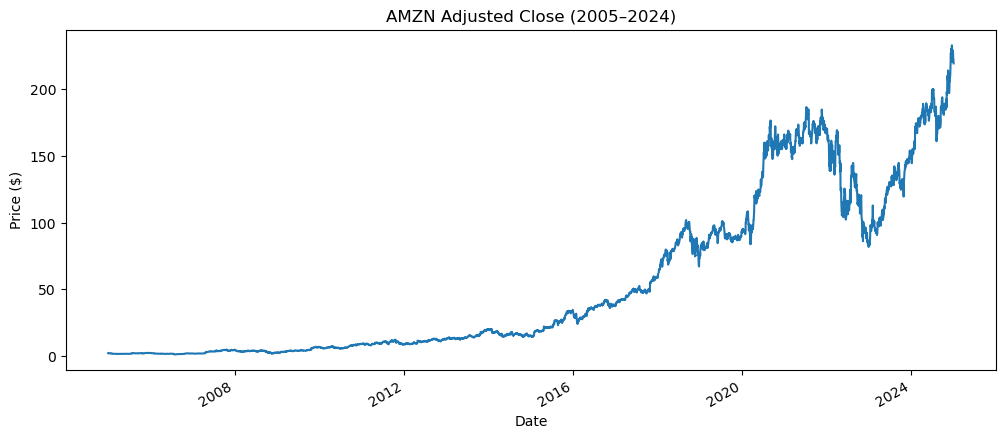

In [59]:
amazon["Price"].plot(figsize=(12,5), title="AMZN Adjusted Close (2005–2024)", ylabel="Price ($)", xlabel="Date")

<Axes: title={'center': 'SP500 Adjusted Close (2005–2024)'}, xlabel='Date', ylabel='Price ($)'>

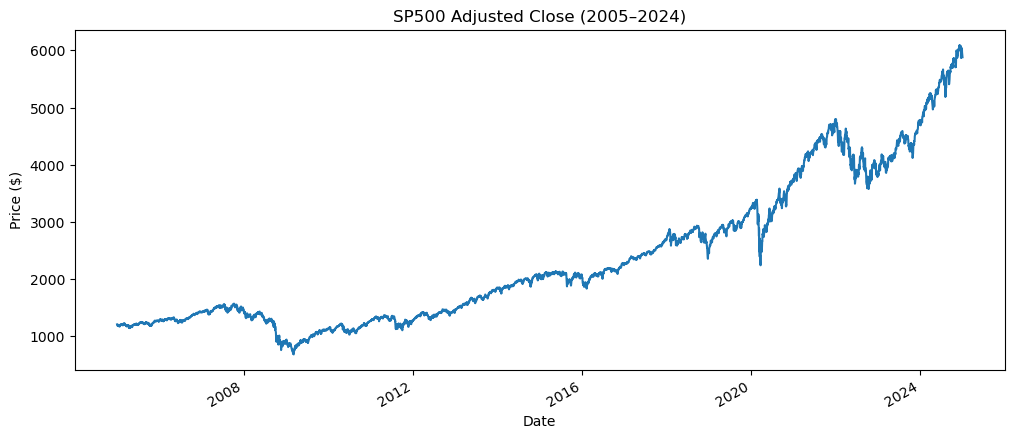

In [60]:
sp500["Price"].plot(figsize=(12,5), title="SP500 Adjusted Close (2005–2024)", ylabel="Price ($)", xlabel="Date")

The AMZN and S&P 500 price series both exhibit strong long-term upward trends, punctuated by periods of rapid growth and significant market corrections.

For AMZN, the growth is more pronounced and volatile, reflecting firm-specific dynamics such as expansion phases, innovation cycles, and higher sensitivity to market sentiment. The S&P 500, as a broad market index, displays a smoother but still clearly trending upward trajectory, capturing overall market growth over the past two decades.

Both series are clearly non-stationary, meaning their statistical properties (mean and variance) evolve over time. This non-stationarity makes direct price prediction challenging and motivates the transformation to returns in later steps of the analysis.

The presence of distinct market regimes (including the 2008 financial crisis, the prolonged bull market of the 2010s, the COVID-19 crash, and the recent inflationary period) further justifies the use of a long historical window. Modeling across multiple regimes improves robustness and reduces the risk of learning patterns specific to only one market phase.

Finally, comparing AMZN to the S&P 500 provides a useful benchmark perspective, allowing us to later distinguish between market-driven movements and stock-specific behavior.

## 6. Daily Returns

To better analyze price movements, we compute **daily returns**:

*Return_t = $r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$*

Returns are useful because:
- they represent *relative* change instead of raw price,
- they are often closer to stationary than price levels,
- they help quantify volatility and extreme movements.

Even if our final target is the price, returns are essential for understanding the dataset and market dynamics.

In [61]:
#We calculate the daily returns for both Amazon and the S&P 500 by computing the percentage change in the `Price` column.
amazon["Return"] = amazon["Price"].pct_change()
sp500["Return"] = sp500["Price"].pct_change()

In [62]:
print("\nAMAZON PRICE AND RETURN:")
amazon[["Price","Return"]].head()


AMAZON PRICE AND RETURN:


Price,Price,Return
Date,,
2005-01-03,2.2260,NaN
2005-01-04,2.1070,-0.053459
2005-01-05,2.0885,-0.008780
2005-01-06,2.0525,-0.017237
2005-01-07,2.1160,0.030938


In [63]:
print("\nS&P 500 PRICE AND RETURN:")
sp500[["Price","Return"]].head()


S&P 500 PRICE AND RETURN:


Price,Price,Return
Date,,
2005-01-03,1202.079956,NaN
2005-01-04,1188.050049,-0.011671
2005-01-05,1183.739990,-0.003628
2005-01-06,1187.890015,0.003506
2005-01-07,1186.189941,-0.001431


## 7a. Returns Distribution

We inspect the distribution of daily returns:
- to see typical daily movement magnitude,
- to detect heavy tails (extreme events),
- to understand whether the data is symmetric or skewed.

This is important because stock returns often deviate from a normal distribution, which can affect model assumptions and evaluation.

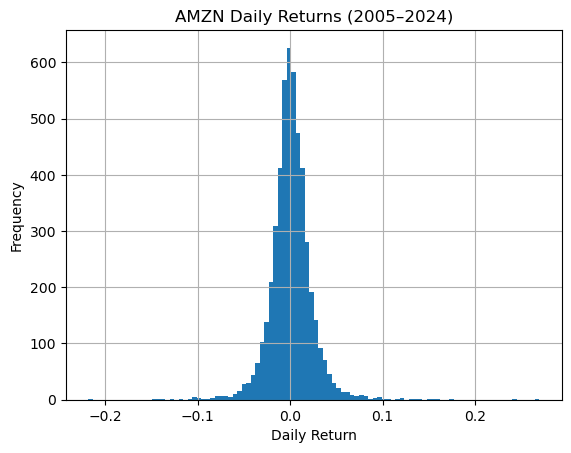

In [64]:
amazon["Return"].hist(bins=100)

plt.title("AMZN Daily Returns (2005–2024)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

plt.show()

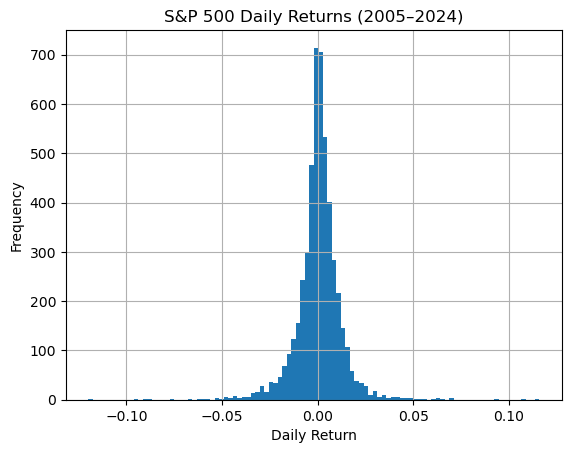

In [65]:
sp500["Return"].hist(bins=100)

plt.title("S&P 500 Daily Returns (2005–2024)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

plt.show()

The distribution of daily returns for both AMZN and the S&P 500 is centered around zero, indicating that most daily price changes are relatively small and fluctuate around a stable mean.

In both cases, the histograms display a roughly bell-shaped structure, consistent with the typical behavior of financial returns. This suggests that, unlike price levels, returns are closer to being stationary.

However, both distributions exhibit noticeable fat tails, meaning that extreme positive and negative movements occur more frequently than would be predicted by a normal distribution. These tail events correspond to periods of market stress such as the 2008 financial crisis and the COVID-19 shock.

Comparatively, AMZN shows a wider dispersion of returns than the S&P 500, reflecting higher idiosyncratic risk and greater sensitivity to firm-specific news and growth expectations. The S&P 500, being a diversified index, exhibits a more concentrated distribution around zero, indicating lower volatility at the aggregate market level.

This behavior is characteristic of financial time series and underscores the importance of using models that are robust to volatility clustering and sudden market shocks.

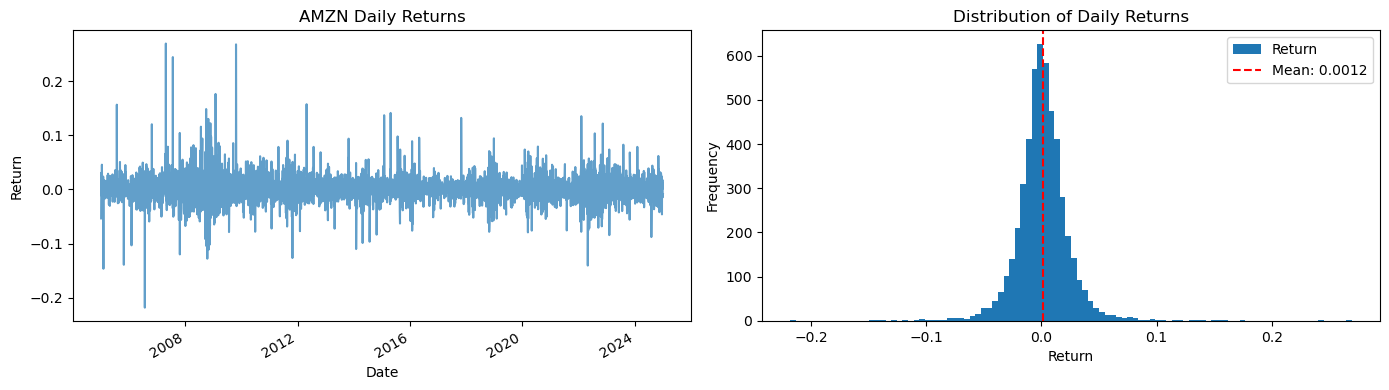

Skewness: 0.8812
Kurtosis: 15.0329


In [66]:
amazon["Return"] = amazon["Price"].pct_change()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

amazon["Return"].plot(ax=axes[0], title="AMZN Daily Returns", ylabel="Return", xlabel="Date", alpha=0.7)

amazon["Return"].dropna().plot(kind="hist", bins=100, ax=axes[1], title="Distribution of Daily Returns", xlabel="Return")
axes[1].axvline(amazon["Return"].mean(), color="red", linestyle="--", label=f"Mean: {amazon['Return'].mean():.4f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Skewness: {amazon['Return'].skew():.4f}")
print(f"Kurtosis: {amazon['Return'].kurtosis():.4f}")

The time series of daily returns fluctuates around zero, confirming the absence of a long-term trend in returns. However, the volatility is clearly not constant over time. Periods such as the 2008 financial crisis and the COVID-19 shock display clusters of large movements, illustrating the well-known phenomenon of volatility clustering in financial markets.

The histogram shows that the distribution of returns is centered close to zero (mean ≈ 0.0012), indicating that most daily price changes are relatively small. This supports the idea that returns are closer to being stationary compared to raw prices.

However, the distribution is not normal. The positive skewness (≈ 0.88) indicates a longer right tail, meaning that large positive returns occur slightly more frequently than large negative ones. More importantly, the very high kurtosis (≈ 15) reveals the presence of fat tails. Extreme market movements occur much more often than would be predicted by a Gaussian distribution.

These characteristics (volatility clustering, skewness, and excess kurtosis) are stylized facts of financial time series. They suggest that modeling approaches must be robust to heavy tails and sudden shocks, rather than relying on normality assumptions.

The S&P 500 exhibits similar statistical properties to AMZN: returns fluctuate around zero, volatility clustering is present, and the distribution displays fat tails.

However, the dispersion of returns is lower compared to AMZN, reflecting the diversified nature of the index. This suggests that AMZN carries higher idiosyncratic risk, while the S&P 500 primarily captures systematic market risk.

## 7b. Feature Correlation Analysis

In this section, we analyze the linear relationship between AMZN and S&P 500 daily returns.

The objective is to assess the degree to which Amazon’s return dynamics are driven by overall market movements. Measuring correlation allows us to evaluate the strength of their co-movement and distinguish between systematic (market-wide) and idiosyncratic (firm-specific) components.

This analysis is exploratory in nature. Correlation captures linear association only and does not imply causality.

In [67]:
df_corr = pd.concat([amazon["Return"], sp500["Return"]], axis=1)
df_corr.columns = ["AMZN_Return", "SP500_Return"]
df_corr = df_corr.dropna()

df_corr.corr()

,AMZN_Return,SP500_Return
AMZN_Return,1.00000,0.57714
SP500_Return,0.57714,1.00000


The correlation between AMZN and S&P 500 daily returns is approximately 0.58, indicating a moderate positive relationship.

This suggests that Amazon’s returns are significantly influenced by overall market movements (systematic risk), but still retain a substantial idiosyncratic component driven by firm-specific factors.

A correlation below 1 confirms that AMZN does not simply mirror the market and therefore may provide diversification benefits. However, the strength of the relationship implies that broader macroeconomic conditions play an important role in explaining its return dynamics.

It is important to note that correlation measures linear association only and does not imply causality.

## 8. Volatility Over Time (Rolling Standard Deviation)

We compute a rolling volatility measure using the standard deviation of returns over a moving window (e.g., 30 trading days).

This helps identify market regimes:
- calm periods (low volatility),
- crisis periods (high volatility spikes).

Understanding volatility is important because prediction errors tend to increase during turbulent market conditions.

<Axes: title={'center': '30-day rolling volatility'}, xlabel='Date', ylabel='Rolling Std Dev'>

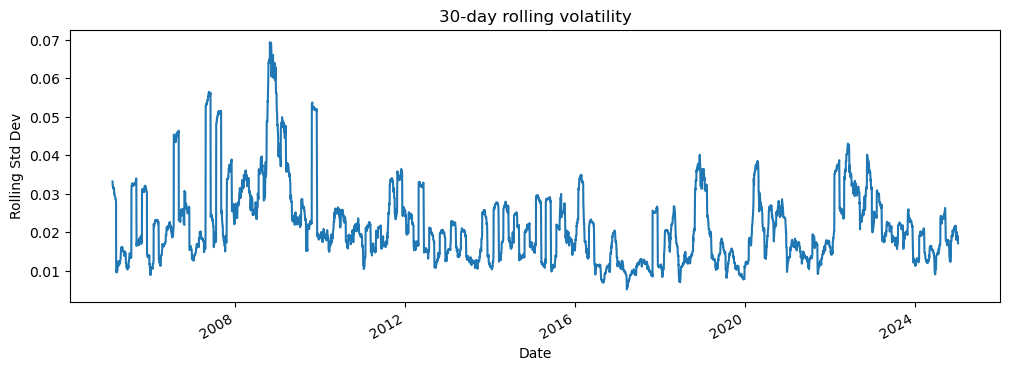

In [68]:
amazon["Return"].rolling(30).std().plot(figsize=(12,4), title="30-day rolling volatility", ylabel="Rolling Std Dev", xlabel="Date")

<Axes: title={'center': '30-day rolling volatility'}, xlabel='Date', ylabel='Rolling Std Dev'>

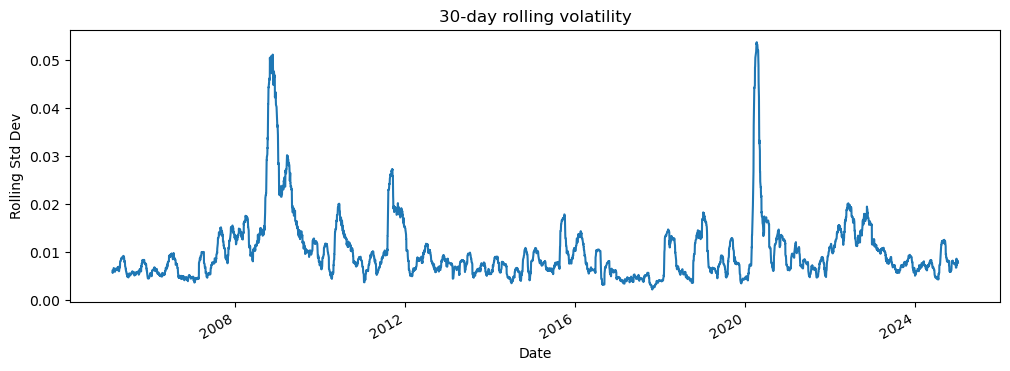

In [69]:
sp500["Return"].rolling(30).std().plot(figsize=(12,4), title="30-day rolling volatility", ylabel="Rolling Std Dev", xlabel="Date")

The rolling 30-day volatility highlights clear regime changes over time for both AMZN and the S&P 500.

Periods such as the 2008 financial crisis and the 2020 COVID-19 shock show pronounced volatility spikes, reflecting elevated uncertainty and large market movements. These spikes confirm the presence of volatility clustering, a well-documented stylized fact in financial markets where turbulent periods tend to group together.

Comparatively, AMZN exhibits consistently higher volatility levels than the S&P 500. This reflects its exposure to firm-specific (idiosyncratic) risk in addition to broader market risk. In contrast, the S&P 500, as a diversified index, shows lower and smoother volatility dynamics.

The time-varying nature of volatility confirms that financial returns are heteroskedastic (their variance is not constant over time). This has important implications for modeling, as prediction errors and risk estimates tend to increase during high-volatility regimes.

Understanding volatility dynamics is therefore crucial for both risk management and predictive modeling.

## 9. Volume Analysis

We analyze trading volume to better understand market activity dynamics.

Volume is often associated with:
- market participation and liquidity,
- reaction to news or macroeconomic events,
- periods of heightened uncertainty.

Because raw volume tends to be highly skewed and non-stationary, we apply a logarithmic transformation to stabilize its scale before interpretation.

We also investigate whether trading volume is related to price direction or to the magnitude of price movements.

<Axes: title={'center': 'AMZN Trading Volume'}, xlabel='Date', ylabel='Volume'>

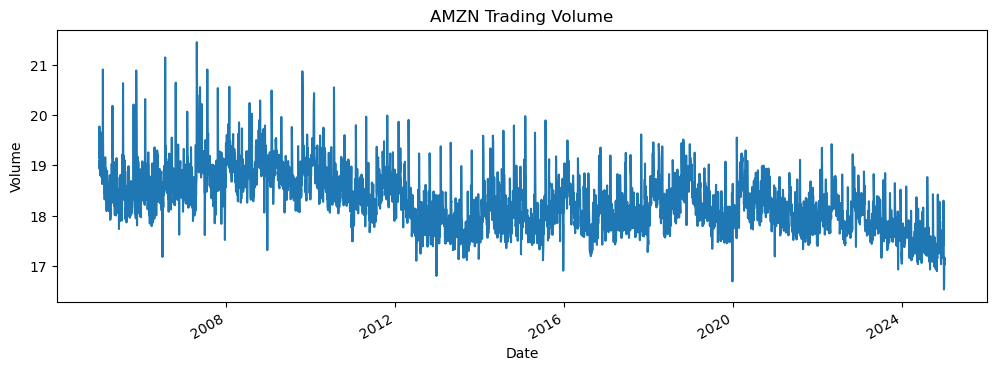

In [70]:
np.log(amazon["Volume"]).plot(figsize=(12,4), title="AMZN Trading Volume", ylabel="Volume", xlabel="Date")

The log-transformed trading volume remains highly variable over time, with noticeable spikes during major market events such as the 2008 financial crisis and the COVID-19 shock.

While volume is noisy and does not follow a stable long-term level, the logarithmic transformation reduces extreme scaling effects and makes temporal patterns easier to observe.

These spikes suggest that trading activity intensifies during periods of market stress or major information releases.

<Axes: title={'center': 'S&P 500 Trading Volume'}, xlabel='Date', ylabel='Volume'>

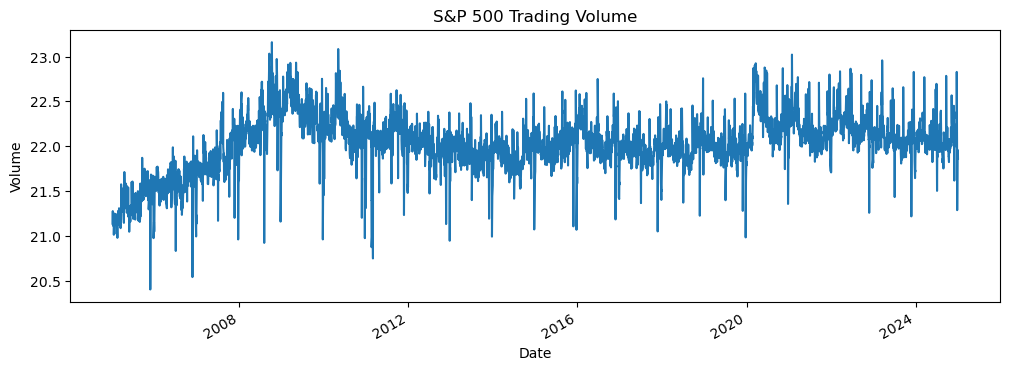

In [71]:
np.log(sp500["Volume"].replace(0, np.nan)).plot(figsize=(12,4), title="S&P 500 Trading Volume", ylabel="Volume", xlabel="Date")

The S&P 500 volume dynamics appear smoother than AMZN’s, reflecting the diversified and aggregate nature of the index.

Although volatility spikes are visible during crisis periods, the overall structure is more stable compared to an individual stock. This difference highlights the stronger idiosyncratic trading activity present in single equities such as AMZN.

### Volume and Return Relationship

In [72]:
amazon["Volume"].corr(amazon["Return"])

0.1117427653558581

In [73]:
amazon["Volume"].corr(amazon["Return"].abs())

0.5899176257129423

The correlation between trading volume and raw returns is relatively low (≈ 0.11), indicating that volume does not meaningfully explain the direction of daily rice movements.

However, the correlation between volume and absolute returns is substantially higher (≈ 0.59). This suggests that trading activity increases when price movements are large, regardless of whether they are positive or negative.

In other words, volume is more strongly associated with the intensity of price movements rather than their sign.

This stylized fact is consistent with financial theory: large market moves typically trigger increased trading activity due to uncertainty, portfolio rebalancing, and behavioral reactions.

## 10. Stationarity Test — Augmented Dickey-Fuller (ADF)

In time series analysis, **stationarity** means that the statistical properties of a series (mean, variance) do not change over time. Most machine learning models implicitly assume some form of stationarity.

The **Augmented Dickey-Fuller (ADF) test** formally tests whether a time series has a unit root (i.e., is non-stationary):
- **H₀ (null hypothesis)**: the series has a unit root → it is non-stationary.
- **H₁ (alternative)**: the series is stationary.

We apply the test to:
1. The raw price series (expected: non-stationary),
2. The daily returns series (expected: stationary).

This justifies working with **returns** rather than raw prices in our modeling pipeline.

In [74]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test: {name}")
    print(f"  ADF Statistic : {result[0]:.4f}")
    print(f"  p-value       : {result[1]:.6f}")
    print(f"  Critical Values:")
    for key, val in result[4].items():
        print(f"    {key}: {val:.4f}")
    if result[1] < 0.05:
        print("Conclusion: STATIONARY (reject H₀ at 5% significance level)")
    else:
        print("Conclusion: NON-STATIONARY (fail to reject H₀)")

adf_test(amazon["Price"], "AMZN Adjusted Close Price")
adf_test(amazon["Return"], "AMZN Daily Returns")
adf_test(sp500["Price"], "S&P 500 Adjusted Close")
adf_test(sp500["Return"], "S&P 500 Daily Returns")


ADF Test: AMZN Adjusted Close Price
  ADF Statistic : 1.1557
  p-value       : 0.995665
  Critical Values:
    1%: -3.4317
    5%: -2.8621
    10%: -2.5671
Conclusion: NON-STATIONARY (fail to reject H₀)

ADF Test: AMZN Daily Returns
  ADF Statistic : -52.4641
  p-value       : 0.000000
  Critical Values:
    1%: -3.4317
    5%: -2.8621
    10%: -2.5671
Conclusion: STATIONARY (reject H₀ at 5% significance level)

ADF Test: S&P 500 Adjusted Close
  ADF Statistic : 2.1602
  p-value       : 0.998848
  Critical Values:
    1%: -3.4317
    5%: -2.8621
    10%: -2.5671
Conclusion: NON-STATIONARY (fail to reject H₀)

ADF Test: S&P 500 Daily Returns
  ADF Statistic : -17.6214
  p-value       : 0.000000
  Critical Values:
    1%: -3.4317
    5%: -2.8621
    10%: -2.5671
Conclusion: STATIONARY (reject H₀ at 5% significance level)


The ADF test confirms that both AMZN and S&P 500 price series are non-stationary, while their daily return series are stationary. This validates the decision to model returns instead of raw prices in the predictive framework.

## 12. Autocorrelation Analysis — ACF & PACF

**Autocorrelation** measures the linear relationship between a time series and its own lagged values. Understanding autocorrelation helps us:
- determine whether past returns are predictive of future returns,
- select appropriate lag values for feature engineering,
- decide whether classical time series models (ARIMA) or ML-based approaches are more suitable.

We compute:
- **ACF (Autocorrelation Function)**: correlation between the series and each of its lags.
- **PACF (Partial Autocorrelation Function)**: correlation after removing the effect of intermediate lags.

We also look at **squared returns** to detect volatility clustering (ARCH effects), which is common in financial data.

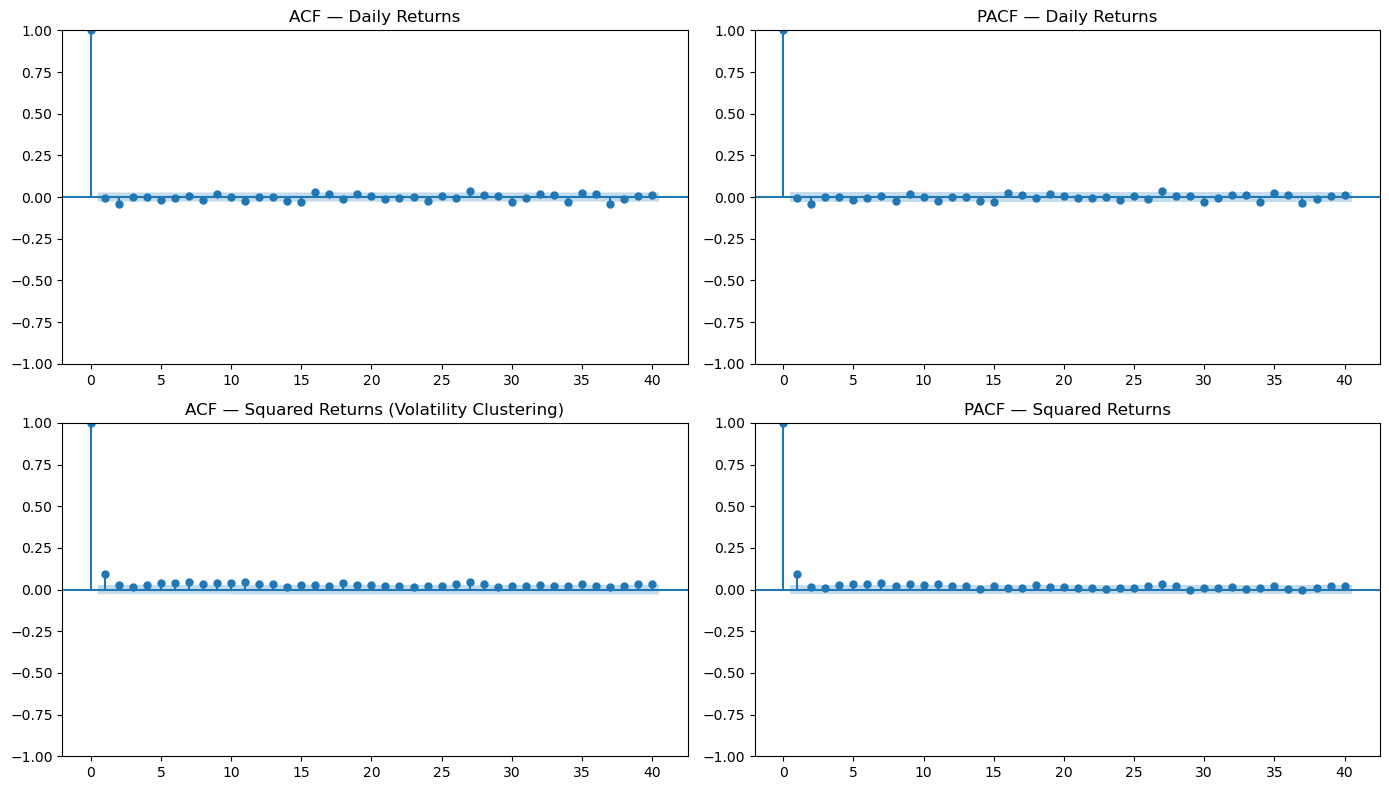

In [75]:
returns_clean = amazon["Return"].dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF on returns
plot_acf(returns_clean, lags=40, ax=axes[0, 0], title="ACF — Daily Returns")

# PACF on returns
plot_pacf(returns_clean, lags=40, ax=axes[0, 1], title="PACF — Daily Returns", method="ywm")

# ACF on squared returns (volatility clustering)
plot_acf(returns_clean**2, lags=40, ax=axes[1, 0], title="ACF — Squared Returns (Volatility Clustering)")

# PACF on squared returns
plot_pacf(returns_clean**2, lags=40, ax=axes[1, 1], title="PACF — Squared Returns", method="ywm")

plt.tight_layout()
plt.show()

**Daily Returns (top row):** The ACF and PACF plots show little to no significant autocorrelation in raw returns. Most lags fall within the confidence bands, suggesting that past returns have very limited linear predictive power over future returns. This is consistent with the weak form of the Efficient Market Hypothesis.

**Squared Returns (bottom row):** In contrast, squared returns (a proxy for variance) show **strong and persistent autocorrelation**. This is the signature of **volatility clustering**: periods of high volatility tend to follow periods of high volatility. This ARCH effect is well-known in financial data and justifies the use of volatility-based features in our model.

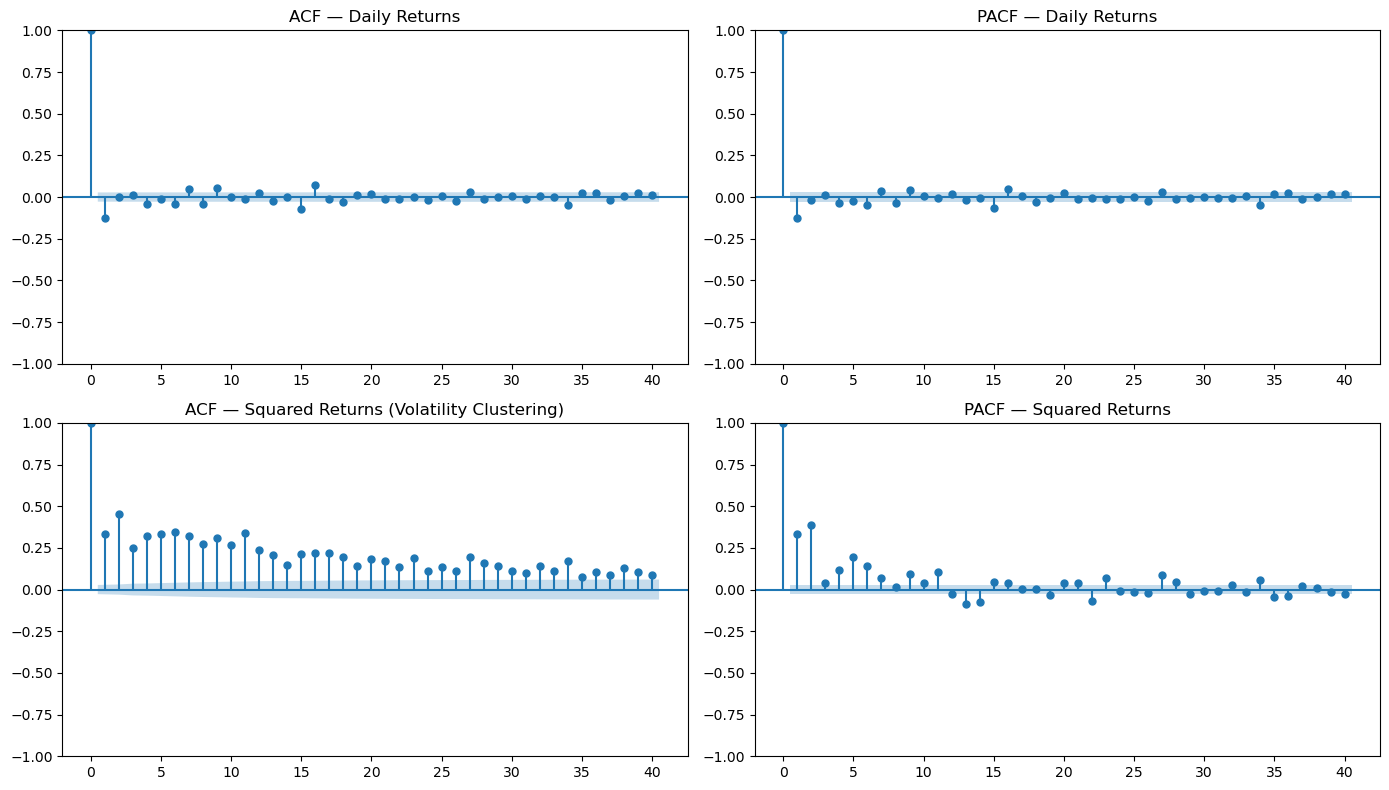

In [76]:
returns_clean = sp500["Return"].dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF on returns
plot_acf(returns_clean, lags=40, ax=axes[0, 0], title="ACF — Daily Returns")

# PACF on returns
plot_pacf(returns_clean, lags=40, ax=axes[0, 1], title="PACF — Daily Returns", method="ywm")

# ACF on squared returns (volatility clustering)
plot_acf(returns_clean**2, lags=40, ax=axes[1, 0], title="ACF — Squared Returns (Volatility Clustering)")

# PACF on squared returns
plot_pacf(returns_clean**2, lags=40, ax=axes[1, 1], title="PACF — Squared Returns", method="ywm")

plt.tight_layout()
plt.show()

The S&P 500 exhibits similar dynamics to AMZN. The ACF and PACF plots show little to no significant autocorrelation in raw returns, indicating limited linear predictability in daily market movements. 

However, squared returns display strong and persistent autocorrelation, confirming the presence of volatility clustering at the market level. This stylized fact suggests that while return direction is difficult to forecast, volatility dynamics contain meaningful temporal structure.

## 13. Calendar Effects (Seasonality)

Financial markets are known to exhibit calendar anomalies — systematic patterns in returns based on the time of year or day of the week. While these effects are often small and debated in academic literature, they are worth quantifying:

- **Day-of-week effect**: Do returns differ systematically on Mondays vs Fridays?
- **Month-of-year effect**: Is there a "January effect" or stronger performance in specific months?

We visualize average daily returns grouped by weekday and by month.

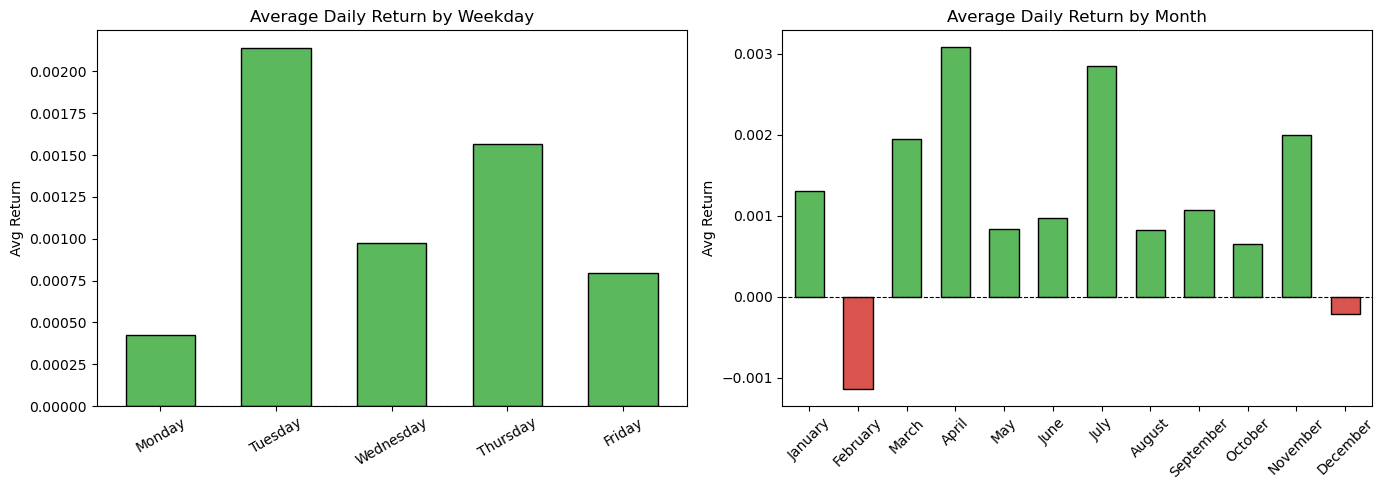

In [77]:
df_calendar = amazon[["Return"]].dropna().copy()
df_calendar["Weekday"] = df_calendar.index.day_name()
df_calendar["Month"] = df_calendar.index.month
df_calendar["Month_Name"] = df_calendar.index.month_name()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

avg_by_weekday = df_calendar.groupby("Weekday")["Return"].mean().reindex(weekday_order)
avg_by_month = df_calendar.groupby("Month_Name")["Return"].mean().reindex(month_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_wd = ["#d9534f" if v < 0 else "#5cb85c" for v in avg_by_weekday]
avg_by_weekday.plot(kind="bar", ax=axes[0], color=colors_wd, edgecolor="black", width=0.6)
axes[0].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[0].set_title("Average Daily Return by Weekday")
axes[0].set_ylabel("Avg Return")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=30)

colors_mo = ["#d9534f" if v < 0 else "#5cb85c" for v in avg_by_month]
avg_by_month.plot(kind="bar", ax=axes[1], color=colors_mo, edgecolor="black", width=0.6)
axes[1].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[1].set_title("Average Daily Return by Month")
axes[1].set_ylabel("Avg Return")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

The weekday analysis shows mild variations in average returns across days of the week. Monday and Friday tend to show slightly different behavior, though the differences are modest over a 20-year horizon.

The monthly analysis reveals that certain months (like April and November) historically show stronger average returns for AMZN, while others (like September and October) tend to be weaker — a pattern loosely consistent with broader market seasonality studies.

While these effects are small in absolute magnitude, they confirm that calendar-based features (day of week, month) may carry marginal predictive signal and are worth including in our feature engineering step.

## 14. Rolling Correlation with S&P 500

Amazon is part of the S&P 500 index, so its returns naturally correlate with the broader market. However, this **correlation is not constant over time** — it can vary significantly depending on macroeconomic regimes, sector rotations, or company-specific events.

We compute the **60-day rolling correlation** between AMZN returns and S&P 500 returns. A high rolling correlation means AMZN is moving in sync with the market (beta-driven), while a lower correlation indicates more idiosyncratic behavior.

Understanding this dynamic is important because:
- it helps identify periods where market-wide signals are more vs. less informative,
- it justifies including SP500 as a feature while acknowledging its time-varying relevance.

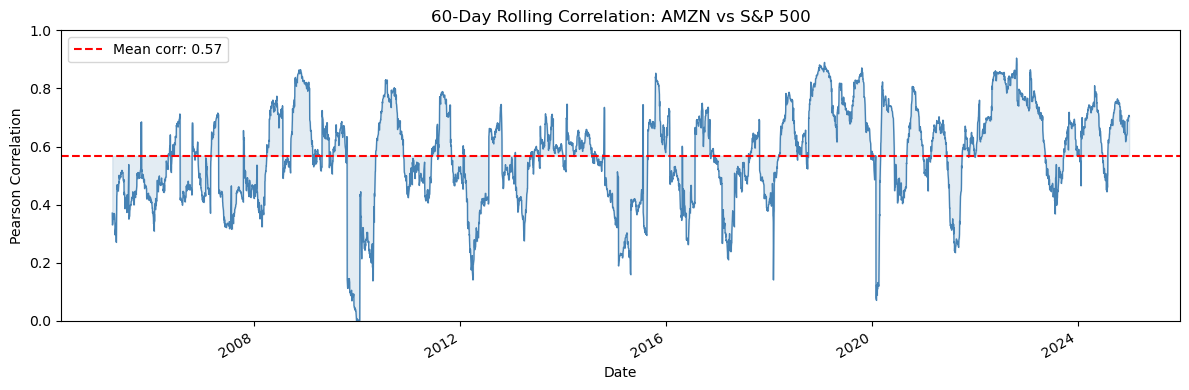

Average 60-day rolling correlation: 0.5684
Min: -0.0157 | Max: 0.9044


In [78]:
combined = pd.DataFrame({
    "AMZN_Return": amazon["Return"],
    "SP500_Return": sp500["Return"]
}).dropna()

rolling_corr = combined["AMZN_Return"].rolling(window=60).corr(combined["SP500_Return"])

fig, ax = plt.subplots(figsize=(12, 4))
rolling_corr.plot(ax=ax, color="steelblue", linewidth=1)
ax.axhline(rolling_corr.mean(), color="red", linestyle="--", label=f"Mean corr: {rolling_corr.mean():.2f}")
ax.fill_between(rolling_corr.index, rolling_corr, rolling_corr.mean(), alpha=0.15, color="steelblue")
ax.set_title("60-Day Rolling Correlation: AMZN vs S&P 500")
ax.set_ylabel("Pearson Correlation")
ax.set_xlabel("Date")
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"Average 60-day rolling correlation: {rolling_corr.mean():.4f}")
print(f"Min: {rolling_corr.min():.4f} | Max: {rolling_corr.max():.4f}")

The 60-day rolling correlation between AMZN and the S&P 500 remains positive on average (~0.57), confirming that AMZN is largely driven by broader market dynamics. However, the correlation is clearly time-varying, increasing during systemic crises (e.g., 2008, 2020) and declining during firm-specific periods. 

This supports the inclusion of S&P 500 returns as an exogenous variable in the SARIMAX model while acknowledging that market influence is not constant over time.

## 15. Drawdown Analysis

A **drawdown** measures how far the price has fallen from its most recent peak. It is one of the most important risk metrics in finance:

$$\text{Drawdown}_t = \frac{P_t - \max_{s \leq t} P_s}{\max_{s \leq t} P_s}$$

Analyzing drawdowns allows us to:
- identify the worst historical loss periods and link them to known events,
- understand the risk profile of AMZN as an asset,
- This analysis provides additional insight into the historical risk profile of AMZN.

We annotate the most significant drawdowns with the associated market events.

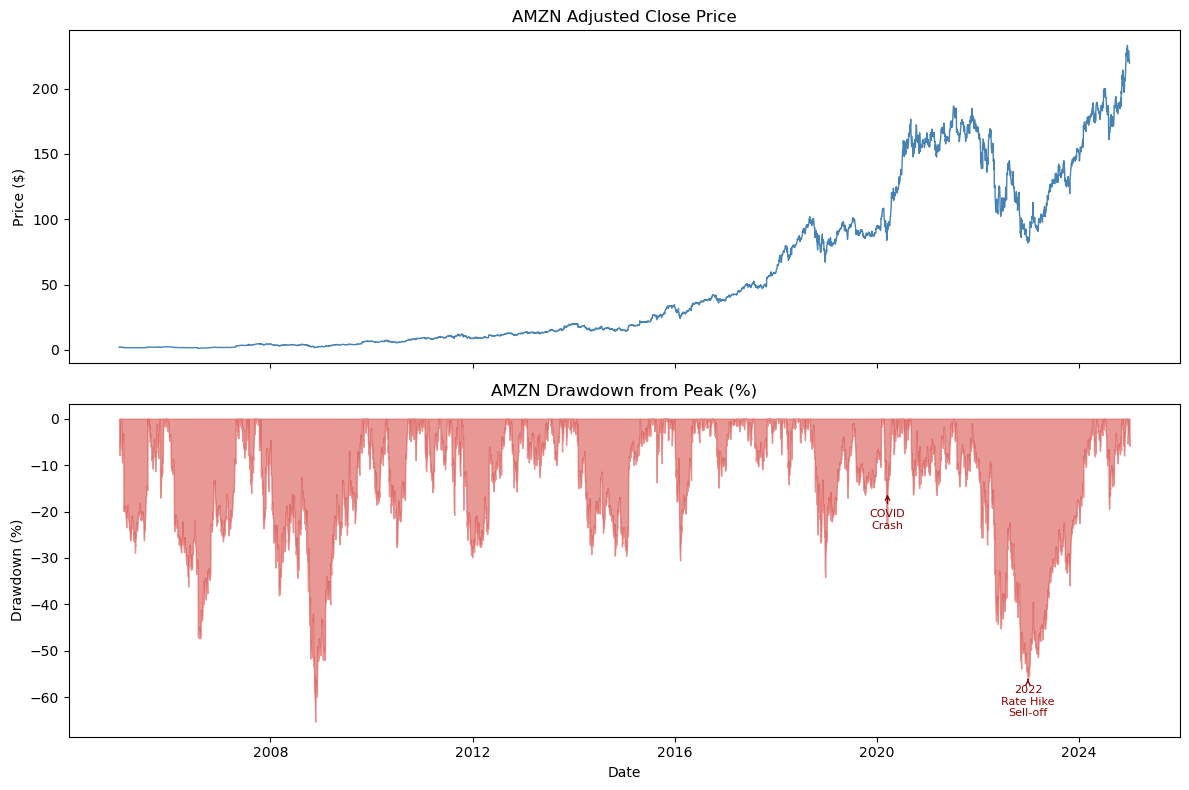

Maximum drawdown: -65.25%
Date of max drawdown: 2008-11-20


In [79]:
price = amazon["Price"]
rolling_max = price.cummax()
drawdown = (price - rolling_max) / rolling_max

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Price
axes[0].plot(price, color="steelblue", linewidth=1)
axes[0].set_title("AMZN Adjusted Close Price")
axes[0].set_ylabel("Price ($)")

# Drawdown
axes[1].fill_between(drawdown.index, drawdown * 100, 0, color="#d9534f", alpha=0.6)
axes[1].set_title("AMZN Drawdown from Peak (%)")
axes[1].set_ylabel("Drawdown (%)")
axes[1].set_xlabel("Date")

# Annotate major drawdowns
events = {
    "2008-11-01": "2008\nFinancial Crisis",
    "2020-03-18": "COVID\nCrash",
    "2022-12-28": "2022\nRate Hike\nSell-off",
}
for date_str, label in events.items():
    date = pd.Timestamp(date_str)
    if date in drawdown.index:
        val = drawdown.loc[date] * 100
        axes[1].annotate(label, xy=(date, val), xytext=(date, val - 8),
                         fontsize=8, ha="center", color="darkred",
                         arrowprops=dict(arrowstyle="->", color="darkred", lw=1))

plt.tight_layout()
plt.show()

print(f"Maximum drawdown: {drawdown.min()*100:.2f}%")
print(f"Date of max drawdown: {drawdown.idxmin().date()}")

The drawdown analysis reveals that AMZN has experienced several severe peak-to-trough declines over the 2005–2024 period. The deepest drawdown occurred during the 2008–2009 financial crisis, followed by significant corrections during the COVID crash of March 2020 (though recovery was rapid) and the 2022 bear market driven by aggressive interest rate hikes.

These drawdown periods are precisely the phases where predictive models face the greatest challenge: volatility spikes, correlations break down, and historical patterns may not hold. Recognizing these episodes in the data will help us evaluate model performance not just on average, but specifically during stress scenarios.

Major drawdown periods correspond to structural breaks in financial markets. 
These regimes are typically associated with higher volatility and reduced forecast stability, 
which may impact model performance during stress periods.

## 14. Output Saving

At the end of this notebook, we save:
- the raw dataset (cleaned column format),
- and a version with basic engineered columns (e.g., Price, Return, SP500).

These outputs will be reused in:
- Notebook 2: model training,
- Notebook 3: evaluation and visualization.

In [80]:
amazon["SP500_Return"] = sp500["Return"].reindex(amazon.index)

print("Rows before dropna:", len(amazon))
amazon_sp500 = amazon.dropna()
print("Rows after dropna:", len(amazon_sp500))

Rows before dropna: 5033
Rows after dropna: 5032


In [81]:
amazon_sp500.to_csv("../data/raw/amzn_sp500_clean.csv")

## Conclusion

The exploratory analysis confirmed several key characteristics of financial time series. 
AMZN prices exhibit a strong long-term trend and non-stationary behavior, while daily returns are stationary and centered around zero. Autocorrelation analysis suggests limited linear predictability in returns, consistent with the weak form of the Efficient Market Hypothesis.

However, squared returns display persistent autocorrelation, indicating volatility clustering. Additionally, AMZN returns show a strong and time-varying correlation with the S&P 500, justifying the inclusion of market information in a multivariate framework.

These findings guide our modeling strategy. In the next notebook, we will:

- Model conditional mean dynamics using ARIMA,
- Extend to SARIMAX to incorporate S&P 500 returns as an exogenous factor,
- Model conditional variance dynamics using GARCH to capture volatility clustering.

This structured approach allows us to separately model return predictability and volatility dynamics, providing a comprehensive time-series forecasting framework.

**Next step: Models Training (Notebook 2).**

### Note on Data Leakage

At this stage, only descriptive transformations were performed (returns and rolling statistics for visualization purposes). No prediction targets were defined and no models were trained.

In the next notebook, train/test splits will be strictly chronological to preserve the time-series structure and avoid look-ahead bias.